# *Classifying newsires: A multiclass classification example*

By now you have understood Binary Classification, which is used when there is a need to classify 2 different classes. 

In this notebook, we'll build a model to classify Reuters newswires into 46 mutually exclusive topics. Since it has 46 classes, it is called *multiclass classification*, and because each data point should be classified into only one category, the problem is more specifically an instance of *single-label multiclass classfication*. If each data point could belong to multiple categories, we'd be facing a *multilabel multiclass classification* problem.

Let's start our problem by importing libraries. The dataset we are using for this example is the Reuters dataset.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import reuters
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (8, 8)

## The Reuters dataset

The Reuters dataset, a set short newsires and their topics, published by Reuters in 1986. There are 46 different topics, some topics are more represented than others but each topic has at least 10 examples in the training set.

Let's load our dataset.

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Same with the IMDB dataset, the argument `num_words` restricts data to the 10,000 most frequently occured words found in the data. 

Let's start examine our training and test set.

In [3]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982,) (8982,)
(2246,) (2246,)


In [4]:
print(train_data[0])
print(train_labels[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


We have 8982 training samples and 2246 testing samples. Each sample's data contains a list of integers as word indices and each label contains one integer between 0 and 45 - a topic index, quite similar to the IMDB dataset.

To decode it back to words, you can do the similar thing with the IMDB dataset.

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


And of course we have to vectorize our data in order to feed it to our neural network.

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

For labels, to vectorize them you need to do what's called *one-hot encoding*. One-hot encoding is a widely used format for categorical data, also called *categorical encoding*. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [7]:
def to_one_hot(labels, dimensions=46):
    results = np.zeros((len(labels), dimensions))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

There is a built-in function in Keras that can do this

In [8]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## Building the model

This topic-classification problem looks similar to the previous movie-review classification problem: in both cases, we’re trying to classify short snippets of text. But there is a new constraint here: the number of output classes has gone from 2 to 46. The dimensionality of the output space is much larger.

In a stack of `Dense` layers like those we’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. 

In the previous example, we used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason, we are using larger layers. Let's go with 64 units.

In [9]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-09 00:05:31.029773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-09 00:05:31.029993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


There are two different things in this architecture from the previous one:

***First***, the last layer of the model has 46 units instead of just 1. This means for each input sample, the network will output a 46-dimensional vector. Each dimension will encode a different class.

***Second***, instead of using the `sigmoid` activation function, we use `softmax` activation function. This means the model will output a probability distribution over the 46 different output classes. Each dimension in the output vector contains the probability that the sample belongs to that class. The sum over all entries will of course be 1.

Now let's go on by compiling our model. Since this is not a binary classification problem, we can't use `binary_crossentropy` as our loss function. Instead, we will use the `categorical_crossentropy`. One thing to note, if we are not one-hot encoding our labels, we will use `sparse_categorical_crossentropy` instead of `categorical_crossentropy`. 

These loss functions measure the distance between two probability distributions, meaning between the probability distribution output by the model and the true distribution of the labels.

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating the approach

Let's use 1000 samples from our training set as our validation set.

In [11]:
x_val = x_train[:1000]
y_val = y_train[:1000]

partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

Ok we are done preparations now, let's start training the model.

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20


2022-04-09 00:05:32.463707: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-09 00:05:33.399331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 3s 81ms/step - loss: 2.4559 - accuracy: 0.5481 - val_loss: 1.6187 - val_accuracy: 0.6650
Epoch 2/20
 1/16 [>.............................] - ETA: 0s - loss: 1.4993 - accuracy: 0.6836

2022-04-09 00:05:34.882316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 31ms/step - loss: 1.3311 - accuracy: 0.7164 - val_loss: 1.2774 - val_accuracy: 0.7120
Epoch 3/20
16/16 [==============================] - 0s 31ms/step - loss: 1.0024 - accuracy: 0.7823 - val_loss: 1.1190 - val_accuracy: 0.7650
Epoch 4/20
16/16 [==============================] - 0s 27ms/step - loss: 0.8018 - accuracy: 0.8265 - val_loss: 1.0364 - val_accuracy: 0.7770
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6347 - accuracy: 0.8636 - val_loss: 0.9859 - val_accuracy: 0.7880
Epoch 6/20
16/16 [==============================] - 0s 29ms/step - loss: 0.5086 - accuracy: 0.8939 - val_loss: 0.9345 - val_accuracy: 0.8070
Epoch 7/20
16/16 [==============================] - 0s 25ms/step - loss: 0.4106 - accuracy: 0.9148 - val_loss: 0.9238 - val_accuracy: 0.8110
Epoch 8/20
16/16 [==============================] - 1s 35ms/step - loss: 0.3322 - accuracy: 0.9295 - val_loss: 0.9415 - val_accuracy: 0.8050
Epoch 9/20
16/16 [======

After the training session is finished, let's plot down the history to see how the training and validating session goes.

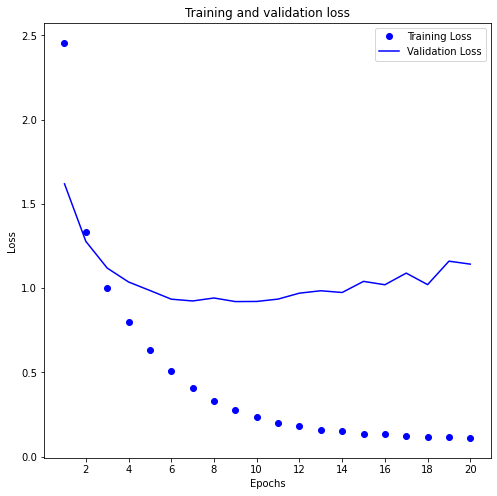

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([epoch for epoch in epochs if epoch % 2 == 0])
plt.legend()
plt.show()

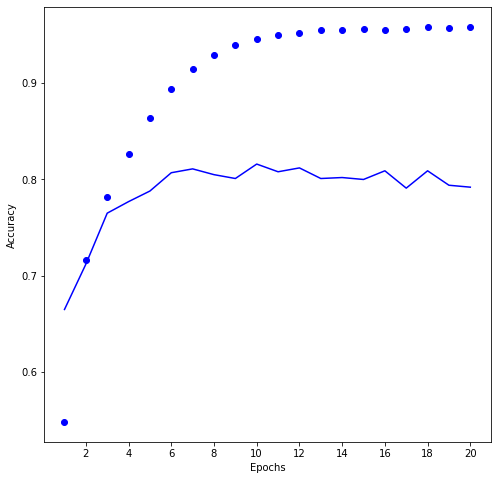

In [14]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
plt.plot(epochs, accuracy_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([epoch for epoch in epochs if epoch % 2 == 0])
plt.show()

We can see that after 8 epochs, the loss value began to rise so we will train a new one with only 8 epochs.

In [15]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

results = model.evaluate(x_test, y_test)

Epoch 1/9


2022-04-09 00:05:46.112682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 33ms/step - loss: 2.3565 - accuracy: 0.5694
Epoch 2/9
18/18 [==============================] - 0s 20ms/step - loss: 1.2717 - accuracy: 0.7232
Epoch 3/9
18/18 [==============================] - 0s 20ms/step - loss: 0.9663 - accuracy: 0.7902
Epoch 4/9
18/18 [==============================] - 0s 20ms/step - loss: 0.7571 - accuracy: 0.8361
Epoch 5/9
18/18 [==============================] - 0s 20ms/step - loss: 0.5989 - accuracy: 0.8772
Epoch 6/9
18/18 [==============================] - 1s 30ms/step - loss: 0.4707 - accuracy: 0.9040
Epoch 7/9
18/18 [==============================] - 0s 27ms/step - loss: 0.3834 - accuracy: 0.9188
Epoch 8/9
18/18 [==============================] - 0s 25ms/step - loss: 0.3076 - accuracy: 0.9321
Epoch 9/9
 5/71 [=>............................] - ETA: 1s - loss: 1.1727 - accuracy: 0.7563 

2022-04-09 00:05:50.625257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 1s 17ms/step - loss: 1.0077 - accuracy: 0.7872


Our approach has and accuracy $\approx$ 80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case, we have 46 classes and they may not be equally represented. Let's try the accuracy of a random classifier. We could try quickly implementing one to check.

In [16]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == test_labels_copy
hits_array.mean()

0.195013357079252

So with a random classifier, it would score around 19% accuracy, so the result of our model is quite decent.

## Generate predictions on new data

In [17]:
predictions = model.predict(x_test)

print(predictions[0].shape)
print(np.sum(predictions[0]))

2022-04-09 00:05:52.237576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(46,)
0.9999999


So each prediction in `predictions` is a 46-dimensional vector and the coefficients in this vector sum to 1, as expected from a probability distribution.

In [18]:
print(np.argmax(predictions[0]))

3


The largest entry in the vector is the predicted class - the class with the highest probability.

## The importance of having sufficiently large intermediate layers

We have mentioned earlier, since the final outputs have 46 units, the precedent layers must have more than 46 units. The reason for that is because if we introduce fewer units, it will compress a lot of information. In the end, it will make our hypothesis space too low-dimensional and cannot cover all necessary information needed to give accurate output.

Let's look at this example to verify.

In [19]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20


2022-04-09 00:14:58.267322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 25ms/step - loss: 3.3524 - accuracy: 0.1491 - val_loss: 2.8615 - val_accuracy: 0.3620
Epoch 2/20
 4/63 [>.............................] - ETA: 1s - loss: 2.7791 - accuracy: 0.3555

2022-04-09 00:15:00.334729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 18ms/step - loss: 2.3768 - accuracy: 0.3934 - val_loss: 2.1291 - val_accuracy: 0.4020
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 1.8401 - accuracy: 0.4421 - val_loss: 1.7951 - val_accuracy: 0.4590
Epoch 4/20
63/63 [==============================] - 1s 23ms/step - loss: 1.5262 - accuracy: 0.5039 - val_loss: 1.6685 - val_accuracy: 0.4830
Epoch 5/20
63/63 [==============================] - 1s 22ms/step - loss: 1.3703 - accuracy: 0.5427 - val_loss: 1.6021 - val_accuracy: 0.5270
Epoch 6/20
63/63 [==============================] - 1s 21ms/step - loss: 1.2357 - accuracy: 0.6007 - val_loss: 1.5082 - val_accuracy: 0.6550
Epoch 7/20
63/63 [==============================] - 2s 35ms/step - loss: 1.0838 - accuracy: 0.7377 - val_loss: 1.4564 - val_accuracy: 0.6910
Epoch 8/20
63/63 [==============================] - 2s 28ms/step - loss: 0.9743 - accuracy: 0.7570 - val_loss: 1.4326 - val_accuracy: 0.6990
Epoch 9/20
63/63 [======

As you can see, the model now peaks at $\approx$ 70%, which is WAY lower than before since the information is compressed and lost due to the fact that there are too few units.

## Wrapping up


Here’s what you should take away from this example:
* If you’re trying to classify data points among *N* classes, your model should end with a `Dense` layer of size *N*.

* In a single-label, multiclass classification problem, your model should end with a `softmax` activation so that it will output a probability distribution over the *N* output classes.

* Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.

* There are two ways to handle labels in multiclass classification:

> * Encoding the labels via categorical encoding (also known as one-hot encoding) and using `categorical_crossentropy` as a loss function.

> * Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.

* If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your model due to intermediate layers that are too small.